In [1]:
from time import time, localtime
import numpy as np
from utils import plot_graph
import tensorflow_federated as tff
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras import losses, metrics, optimizers
import random
import pandas as pd
import sys
import matplotlib.pyplot as plt
import nest_asyncio
from pathlib import Path
from checkpoint_manager import FileCheckpointManager
nest_asyncio.apply()
SEED = 1337
tf.random.set_seed(SEED)


2022-10-28 00:02:04.391327: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-28 00:02:04.533565: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-28 00:02:04.533593: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-28 00:02:04.562180: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-28 00:02:05.235383: W tensorflow/stream_executor/pla

In [2]:
experiment_name = "Iris"
method = "Linear"
client_lr = 1e-4
server_lr = 1e-3
NUM_ROUNDS = 100
BATCH_SIZE = 64


In [3]:
this_dir = Path.cwd()
model_dir = this_dir / "sdn_saved_models" / experiment_name / method
output_dir = this_dir / "sdn_results" / experiment_name / method

if not model_dir.exists():
    model_dir.mkdir(parents=True)

if not output_dir.exists():
    output_dir.mkdir(parents=True)


In [4]:
def sec_to_hours(seconds):
    a = seconds//3600
    b = (seconds % 3600)//60
    c = (seconds % 3600) % 60
    d = "{:.0f} hours {:.0f} mins {:.0f} seconds".format(a, b, c)
    return d


## Data

In [5]:
def sklearn_to_df(sklearn_dataset):
    df = pd.DataFrame(sklearn_dataset.data,
                      columns=sklearn_dataset.feature_names)
    df['target'] = pd.Series(sklearn_dataset.target)
    return df


In [6]:
from sklearn import datasets
df = sklearn_to_df(datasets.load_iris())


In [7]:
df = df.sample(frac=1).reset_index(drop=True)


In [8]:
# Creating Alice and Bob's splits:
alice_df = df[:len(df.index)//2]
bob_df = df[len(df.index)//2:]


### Exploratory Analysis

In [9]:
df['target'].value_counts()


1    50
0    50
2    50
Name: target, dtype: int64

In [10]:
alice_df['target'].value_counts()


2    27
0    26
1    22
Name: target, dtype: int64

In [11]:
bob_df['target'].value_counts()


1    28
0    24
2    23
Name: target, dtype: int64

## Federated Learning Approach

### Data Loading

In [12]:
def make_tf_dataset(dataframe, batch_size=None):

    y = dataframe.pop('target')

    # Dataset creation
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe.values, y.to_frame().values))
    dataset = dataset.shuffle(2048, seed=SEED)
    if batch_size:
        dataset = dataset.batch(batch_size)

    return dataset

In [13]:
train_data, val_data = [], []
for client_data in [alice_df, bob_df]:
    train_df, val_df = train_test_split(
        client_data, test_size=0.2, random_state=SEED)

    # Scaling (Standardization actually hurts performance)
    scaler = MinMaxScaler()
    train_features = scaler.fit_transform(train_df.drop(['target'], axis=1))
    val_features = scaler.transform(val_df.drop(['target'], axis=1))

    train_df[train_df.columns.difference(['target'])] = train_features
    val_df[val_df.columns.difference(['target'])] = val_features

    # TF Datasets
    train_data.append(make_tf_dataset(train_df, batch_size=BATCH_SIZE))
    val_data.append(make_tf_dataset(val_df, batch_size=1))


2022-10-28 00:02:08.271573: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-28 00:02:08.271606: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-28 00:02:08.271622: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (onos-virtual-machine): /proc/driver/nvidia/version does not exist
2022-10-28 00:02:08.271932: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Model Definition

In [209]:
def input_spec():
    return (
        tf.TensorSpec([None, 4], tf.float64),
        tf.TensorSpec([None, 1], tf.int64)
    )

In [210]:
def model_fn():
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(4,)),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    return tff.learning.from_keras_model(
        model,
        input_spec=input_spec(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

### Training

Each time the `next` method is called, the server model is broadcast to each client using a broadcast function. For each client, one epoch of local training is performed. Each client computes the difference between the client model after training and the initial broadcast model. These model deltas are then aggregated at the server using some aggregation function.

In [211]:
tff_train_acc = []
tff_train_loss = []
tff_val_acc = []
tff_val_loss = []

In [212]:
iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(
        learning_rate=client_lr),
    server_optimizer_fn=lambda: tf.keras.optimizers.Adam(
        learning_rate=server_lr)
)

In [213]:
evaluator = tff.learning.build_federated_evaluation(model_fn)


In [214]:
state = iterative_process.initialize()

In [215]:
start = time()

for i in range(NUM_ROUNDS):
    # Train
    result = iterative_process.next(state, train_data)
    state = result.state
    train_metrics = result.metrics['client_work']['train']

    # Validation
    federated_metrics = evaluator(result.state.global_model_weights, val_data)
    val_metrics = federated_metrics['eval']

    # Metrics
    train_loss = train_metrics['loss']
    train_acc = train_metrics['sparse_categorical_accuracy']
    val_loss = val_metrics['loss']
    val_acc = val_metrics['sparse_categorical_accuracy']

    # Print
    print('round {:2d}\ntrain_loss={l:.3f}, train_acc={ac:.3f}'.format(
        i+1, l=train_loss, ac=train_metrics['sparse_categorical_accuracy']))
    print('val_loss: {:.3f} val_acc: {:.3f}'.format(
        val_loss, val_acc))

    # Save
    train_val = str(round(train_acc*100)) + "_" + str(round(val_acc*100))

    # logs
    tff_train_acc.append(float(train_metrics['sparse_categorical_accuracy']))
    tff_train_loss.append(float(train_metrics['loss']))
    tff_val_acc.append(float(val_metrics['sparse_categorical_accuracy']))
    tff_val_loss.append(float(val_metrics['loss']))

end = time() - start


round  1
train_loss=1.052, train_acc=0.417
val_loss: 1.075 val_acc: 0.200
round  2
train_loss=1.044, train_acc=0.450
val_loss: 1.071 val_acc: 0.233
round  3
train_loss=1.036, train_acc=0.450
val_loss: 1.067 val_acc: 0.233
round  4
train_loss=1.027, train_acc=0.467
val_loss: 1.063 val_acc: 0.233
round  5
train_loss=1.019, train_acc=0.492
val_loss: 1.058 val_acc: 0.367
round  6
train_loss=1.011, train_acc=0.517
val_loss: 1.053 val_acc: 0.400
round  7
train_loss=1.002, train_acc=0.575
val_loss: 1.047 val_acc: 0.433
round  8
train_loss=0.993, train_acc=0.617
val_loss: 1.041 val_acc: 0.533
round  9
train_loss=0.984, train_acc=0.650
val_loss: 1.035 val_acc: 0.533
round 10
train_loss=0.975, train_acc=0.667
val_loss: 1.029 val_acc: 0.533
round 11
train_loss=0.966, train_acc=0.675
val_loss: 1.021 val_acc: 0.567
round 12
train_loss=0.956, train_acc=0.675
val_loss: 1.014 val_acc: 0.600
round 13
train_loss=0.946, train_acc=0.683
val_loss: 1.005 val_acc: 0.600
round 14
train_loss=0.936, train_acc=0

In [216]:
total_time = "Time: {}".format(sec_to_hours(end))
print(total_time)


Time: 0 hours 1 mins 0 seconds


In [217]:
this_dir = Path.cwd()
model_dir = this_dir / "sdn_saved_models" / experiment_name / method / train_val
output_dir = this_dir / "sdn_results" / experiment_name / method / train_val

if not model_dir.exists():
    model_dir.mkdir(parents=True)

if not output_dir.exists():
    output_dir.mkdir(parents=True)


### Evaluation

In [218]:
with open(output_dir/'parameters.txt', 'w') as f:
    print('client_lr: {}\nserver_lr: {}\nRounds: {}'.format(
        client_lr, server_lr, NUM_ROUNDS), file=f)
    f.close()


In [219]:
text_file = open(output_dir/"time.txt", "w")
n = text_file.write(total_time)
text_file.close()


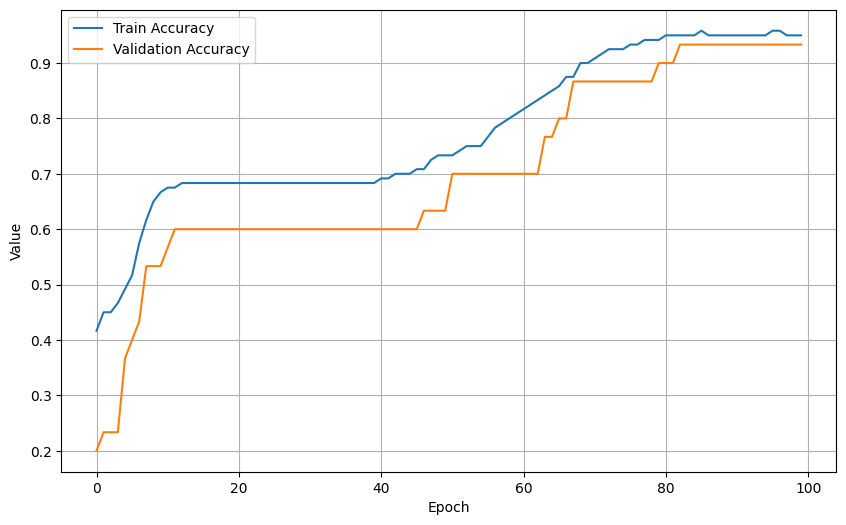

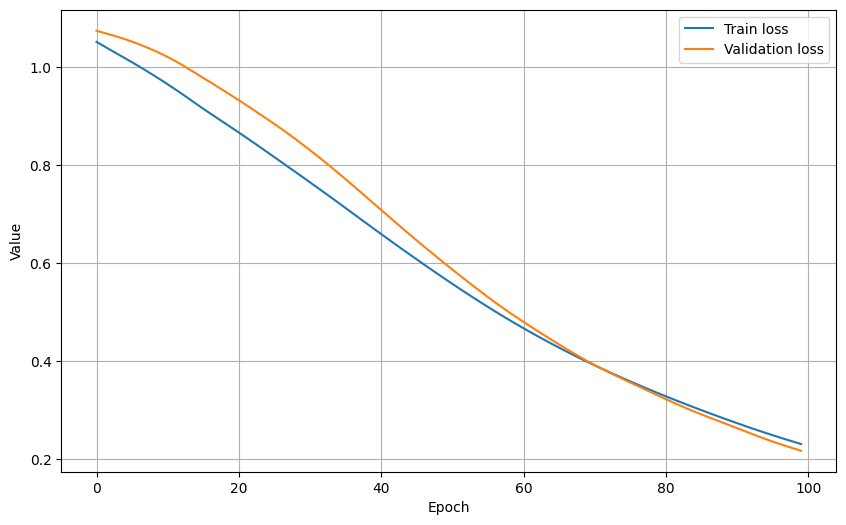

In [220]:
fig = plt.figure(figsize=(10, 6))
plot_graph(list(range(0, NUM_ROUNDS)), tff_train_acc, label='Train Accuracy')
plot_graph(list(range(0, NUM_ROUNDS)), tff_val_acc,
           label='Validation Accuracy')
plt.legend()
plt.savefig(output_dir / "federated_model_Accuracy.png")

plt.figure(figsize=(10, 6))
plot_graph(list(range(0, NUM_ROUNDS)), tff_train_loss, label='Train loss')
plot_graph(list(range(0, NUM_ROUNDS)), tff_val_loss, label='Validation loss')
plt.legend()
plt.savefig(output_dir / "federated_model_loss.png")


## Single Model with all Data at once (for comparison)

### Data Loading

In [221]:
# train_data = train_data[0].concatenate(train_data[1])
# val_data = val_data[0].concatenate(val_data[1])


### Model Definition

In [222]:
# def model_fn():
#     model = tf.keras.models.Sequential([
#         tf.keras.layers.InputLayer(input_shape=(4,)),
#         tf.keras.layers.Dense(32, activation='relu'),
#         tf.keras.layers.Dense(64, activation='relu'),
#         tf.keras.layers.Dense(32, activation='relu'),
#         tf.keras.layers.Dense(3, activation='sigmoid'),
#     ])

#     model.compile(
#         loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#         optimizer=tf.keras.optimizers.Adam(),
#         metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
#     )

#     return model


### Training

In [223]:
# model = model_fn()
# history = model.fit(train_data, epochs=NUM_ROUNDS,verbose=0)


### Evaluation

In [224]:
# test_scores = model.evaluate(val_data)
# single_metrics = {
#     'loss': test_scores[0],
#     'accuracy': test_scores[1],
# }
# single_metrics


## Conclusion

Comparing both models:

In [225]:
# print(f"---Single model metrics---\n{single_metrics}\n")
# print(f"---Federated model metrics---\n{dict(federated_metrics)}")


The Federated Learning approach has a better balance between precision and recall, which might be an indicator of better handling of the imbalanced dataset.